In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression 
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import seaborn as sns
import xgboost as xgb
import math
import statsmodels.api as sm
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
import scipy.stats as stats

In [2]:
df = pd.read_csv('credit_risk.csv')
df

,default_label,age,gender,edu,housing,income,job_occupation,past_bad_credit,married
0,0,49,0,2,1,3782.410356,0,1,1
1,0,62,1,3,1,11516.000660,0,1,1
2,0,43,1,2,1,1746.632495,1,1,1
3,0,59,0,0,0,1195.975234,1,1,1
4,0,58,1,4,1,7217.466097,0,1,1
...,...,...,...,...,...,...,...,...,...
13977,0,36,1,2,1,6856.358688,0,1,0
13978,0,44,0,0,1,2245.684172,0,1,0
13979,0,47,0,1,1,14793.528320,0,1,1
13980,0,62,0,0,1,2118.337362,0,1,1


In [3]:
# create summary table
df_summary = df.describe().T
df_summary.index = df_summary.index.str.replace('_','\_',regex=True)
df_summary.to_latex('table/data_description.tex',columns=['count','mean','std','min','max'],float_format="%.2f",bold_rows=True, caption='Data Description', label='tab:data_description')

In [4]:
default_rate = df['default_label'].sum() / len(df)
print(f'The default rate of sample is {default_rate:.2%}')

The default rate of sample is 2.20%


In [5]:
# plots the roc curve based of the probabilities
def plot_roc_curve(true_y, y_prob, model_name):
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    auc = roc_auc_score(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve of {model_name} (AUC={auc:.2f})')
    plt.savefig(f'./fig/roc_curve_{model_name}.png')
    return [plt, auc]

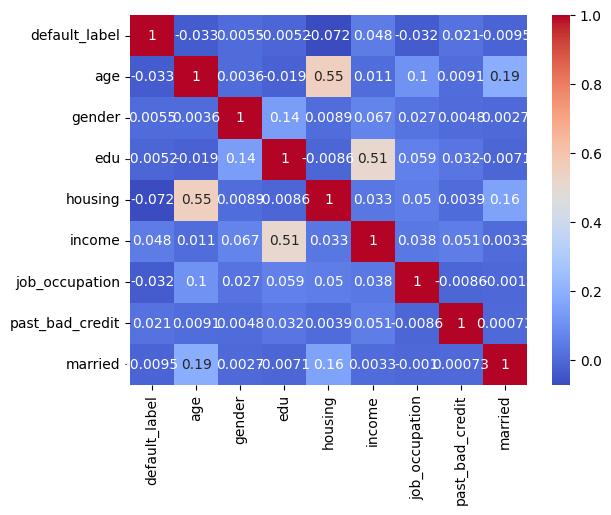

In [6]:
# Plot heatmap
# sns.heatmap(df.drop(columns=['default_label']).corr(), annot=True, cmap='coolwarm')
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

# Save the heatmap as an image
plt.savefig('fig/variable_heatmap.png')

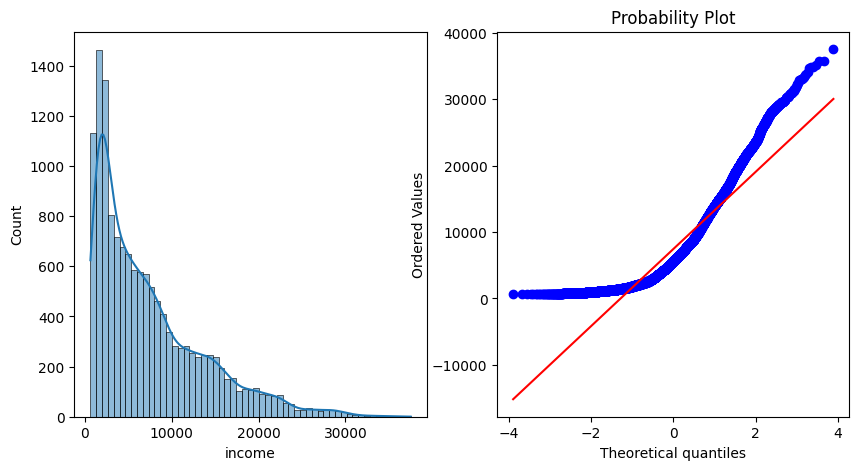

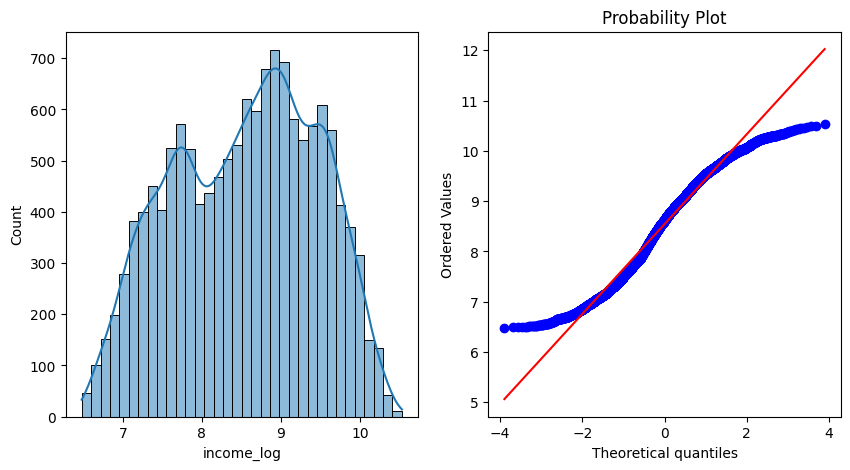

In [7]:
## Transformation of skewed variables
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.histplot(df['income'], kde=True)
plt.subplot(1,2,2)
stats.probplot(df['income'], dist="norm", plot=plt)   # QQ Plot
plt.savefig('./fig/income_distribution.png')

# Log transformation
logTr = ColumnTransformer(transformers=[("lg", FunctionTransformer(np.log1p), ['income'])])
df['income_log'] = logTr.fit_transform(df)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.histplot(df['income_log'], kde=True)
plt.subplot(1,2,2)
stats.probplot(df['income_log'], dist="norm", plot=plt)   # QQ Plot
plt.savefig('./fig/income_distribution_log_transform.png')

# Simple Logistic Model

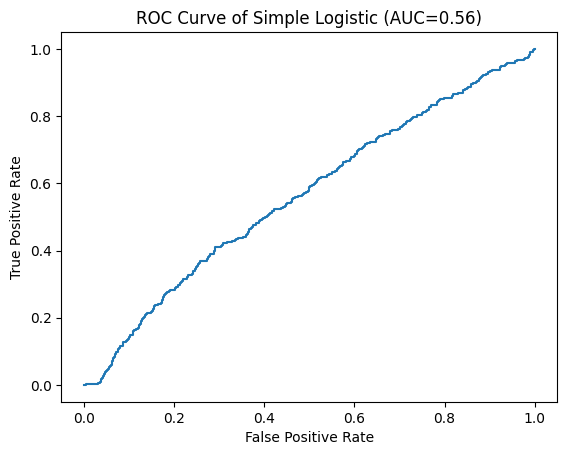

In [11]:
mod = LogisticRegression()
rres = mod.fit(y = df['default_label'], X=df[['past_bad_credit', 'income']])
_, auc_simplog = plot_roc_curve(df['default_label'], mod.predict_proba(df[['past_bad_credit', 'income']])[:,1],'Simple Logistic')

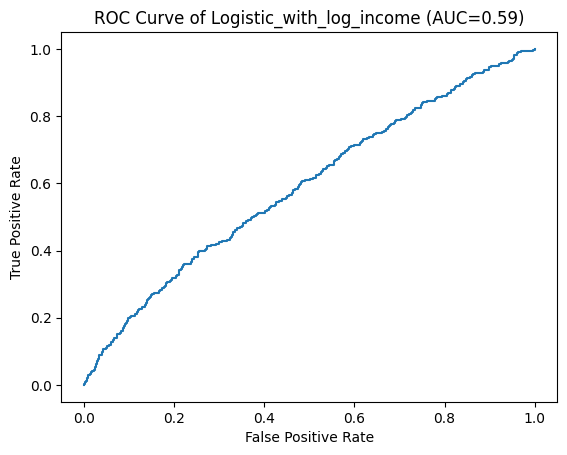

In [12]:
mod = LogisticRegression()
rres = mod.fit(y = df['default_label'], X=df[['past_bad_credit', 'income_log']])
_, auc_simplog_logtransform = plot_roc_curve(df['default_label'], mod.predict_proba(df[['past_bad_credit', 'income_log']])[:,1],'Logistic_with_log_income')

# Full Logistic Model

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


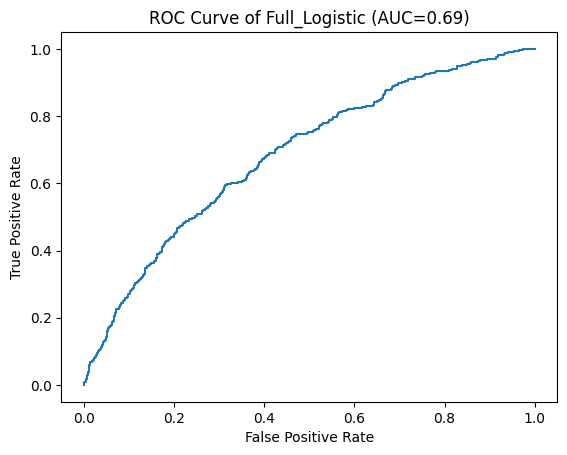

In [17]:
mod = LogisticRegression()
X=df.drop(columns=['default_label','income'])
rres = mod.fit(y = df['default_label'], X=X)
_, auc_log = plot_roc_curve(df['default_label'], mod.predict_proba(X)[:,1],'Full_Logistic')

# SVM/ Random Forest

In [39]:
# Data preparation
X=df.drop(columns=['default_label','income'])

## SVM

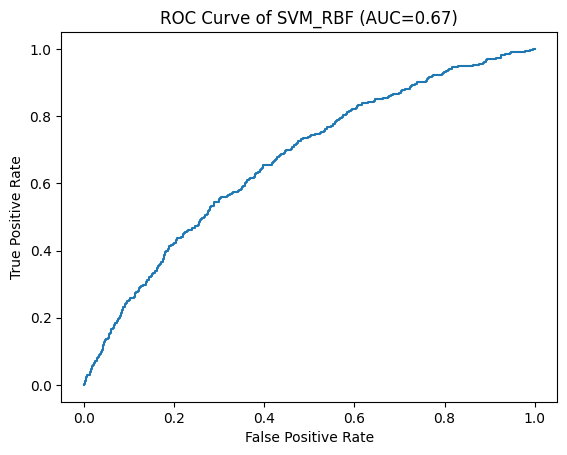

In [37]:
# SVM using RBF kernel
mod = svm.SVC(class_weight='balanced',kernel='rbf', probability=True)
rres = mod.fit(y = df['default_label'], X=X)
_, auc_rbfsvm = plot_roc_curve(df['default_label'], mod.predict_proba(X)[:,1],'SVM_RBF')

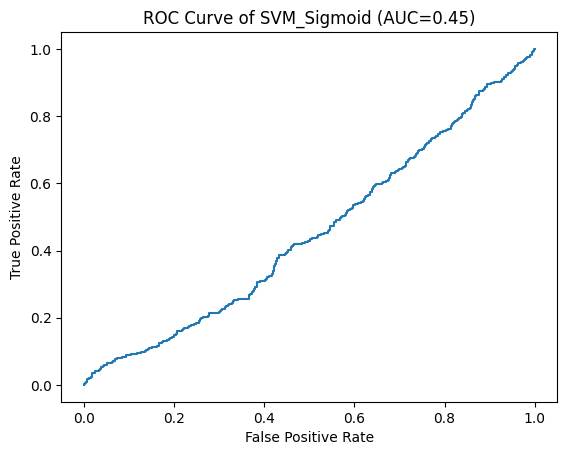

In [38]:
# kernel SVM
mod = svm.SVC(class_weight='balanced',kernel='sigmoid', probability=True)
rres = mod.fit(y = df['default_label'], X=X)
_, auc_sigmoidsvm = plot_roc_curve(df['default_label'], mod.predict_proba(X)[:,1],'SVM_Sigmoid')

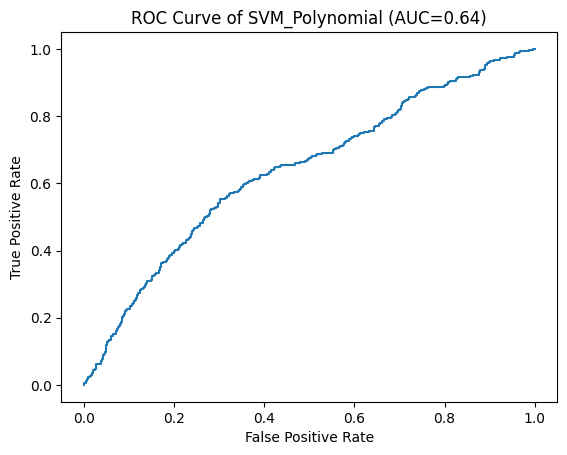

In [40]:
# polynomial kernel SVM
mod = svm.SVC(class_weight='balanced',kernel='poly', probability=True)
rres = mod.fit(y = df['default_label'], X=X)
_, auc_polysvm = plot_roc_curve(df['default_label'], mod.predict_proba(X)[:,1],'SVM_Polynomial')

## Random Forest

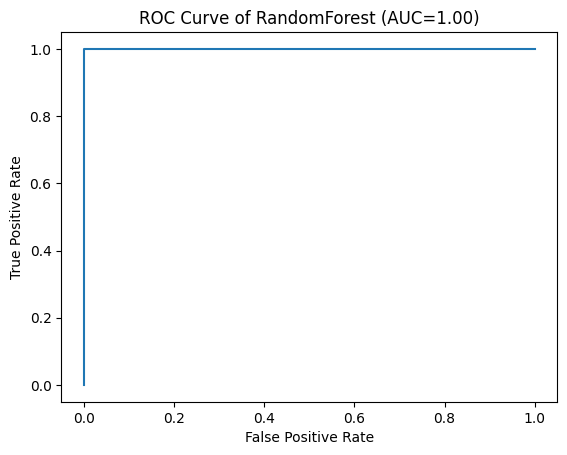

In [41]:
mod = RandomForestClassifier()
rres = mod.fit(y = df['default_label'], X=X)
_, auc_RF = plot_roc_curve(df['default_label'], mod.predict_proba(X)[:,1],'RandomForest')

## Neural Network

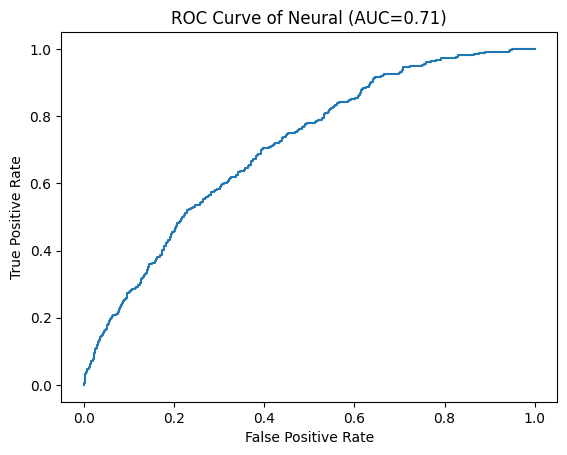

In [42]:
mod = MLPClassifier(hidden_layer_sizes=(100,100), max_iter=1000)
rres = mod.fit(y = df['default_label'], X=X)
_, auc_neural = plot_roc_curve(df['default_label'], mod.predict_proba(X)[:,1],'Neural')

## XGBoosting

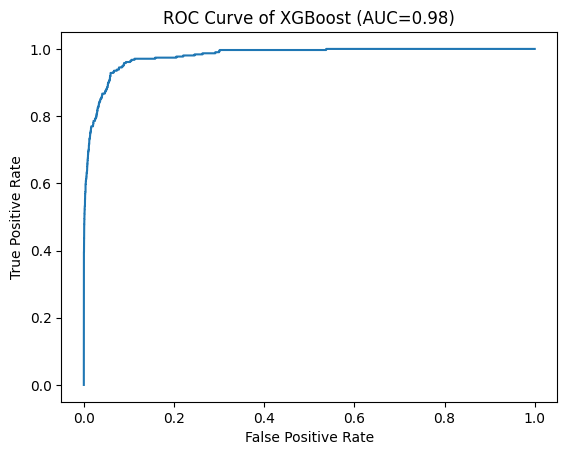

In [43]:
# Create an instance of the XGBoost classifier
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X, df['default_label'])
_, auc_XGBoosting = plot_roc_curve(df['default_label'], xgb_model.predict_proba(X)[:,1],'XGBoost')

# Out-of-Sample Test

In [44]:
df_train = df[:10000]
df_test = df[10001:]
y_train = df_train['default_label']
X_train = df_train.drop(columns=['default_label','income'])
X_test = df_test.drop(columns=['default_label','income'])
y_test = df_test['default_label']

## Logistic

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


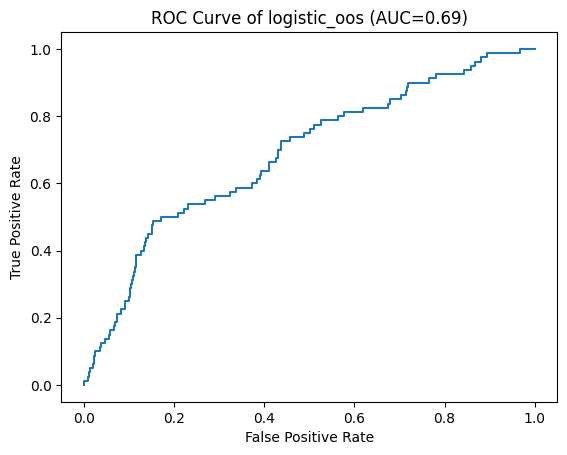

In [45]:
# Create a logistic regression model
logreg = LogisticRegression()
# Fit the model on the training data
logreg.fit(X_train, y_train)

# Plot the ROC curve
_, auc_log_oos = plot_roc_curve(y_test, logreg.predict_proba(X_test)[:,1],'logistic_oos')

## SVM

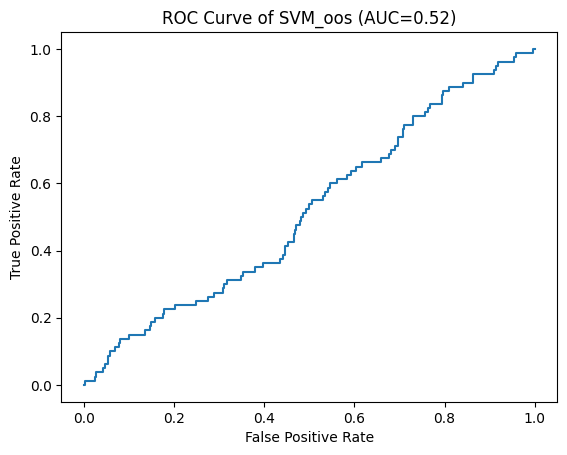

In [46]:
mod = svm.SVC(kernel='rbf', probability=True)
rres = mod.fit(y = y_train, X=X_train)
_, auc_svm_oos = plot_roc_curve(y_test, mod.predict_proba(X_test)[:,1],'SVM_oos')

## Random Forest

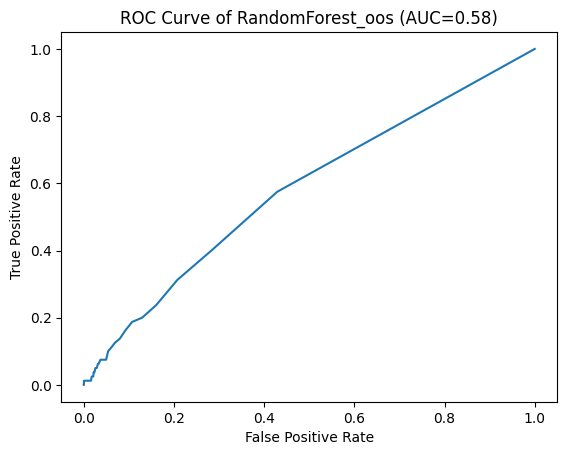

In [47]:
mod = RandomForestClassifier()
rres = mod.fit(y = y_train, X=X_train)
_, auc_RFoos = plot_roc_curve(y_test, mod.predict_proba(X_test)[:,1],'RandomForest_oos')

## XGBoosting
Wu, W. (2022) Machine Learning Approaches to Predict Loan Default. Intelligent Information Management, 14, 157-164. doi: 10.4236/iim.2022.145011.


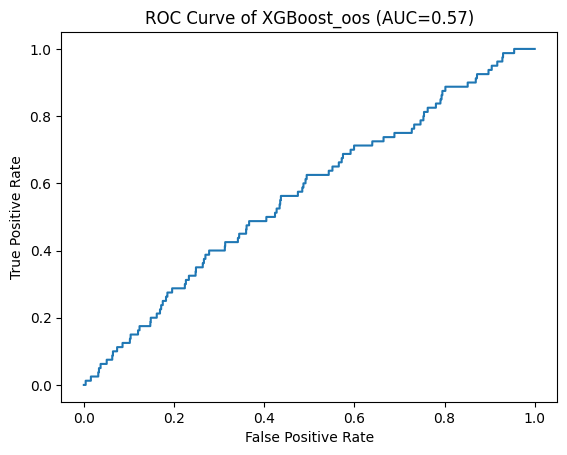

In [48]:
# Create an instance of the XGBoost classifier
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
_, auc_XGBoostingoos = plot_roc_curve(y_test, xgb_model.predict_proba(X_test)[:,1],'XGBoost_oos')

## Neural Network

@article{cite-key,
	abstract = {Default prediction is the primary goal of credit risk management. This problem has long been tackled using well-established statistical classification models. Still, nowadays, the availability of large datasets and cheap software implementations makes it possible to employ machine learning techniques. This paper uses a large sample of small Italian companies to compare the performance of various machine learning classifiers and a more traditional logistic regression approach. In particular, we perform feature selection, use the algorithms for default prediction, evaluate their accuracy, and find a more suitable threshold as a function of sensitivity and specificity. Our outcomes suggest that machine learning is slightly better than logistic regression. However, the relatively small performance gain is insufficient to conclude that classical statistical classifiers should be abandoned, as they are characterized by more straightforward interpretation and implementation.},
	author = {Bazzana, Flavio and Bee, Marco and Hussin Adam Khatir, Ahmed Almustfa},
	date = {2023/11/15},
	date-added = {2024-04-18 21:22:55 +0800},
	date-modified = {2024-04-18 21:22:55 +0800},
	doi = {10.1057/s41283-023-00132-2},
	id = {Bazzana2023},
	isbn = {1743-4637},
	journal = {Risk Management},
	number = {1},
	pages = {1},
	title = {Machine learning techniques for default prediction: an application to small Italian companies},
	url = {https://doi.org/10.1057/s41283-023-00132-2},
	volume = {26},
	year = {2023},
	bdsk-url-1 = {https://doi.org/10.1057/s41283-023-00132-2}}


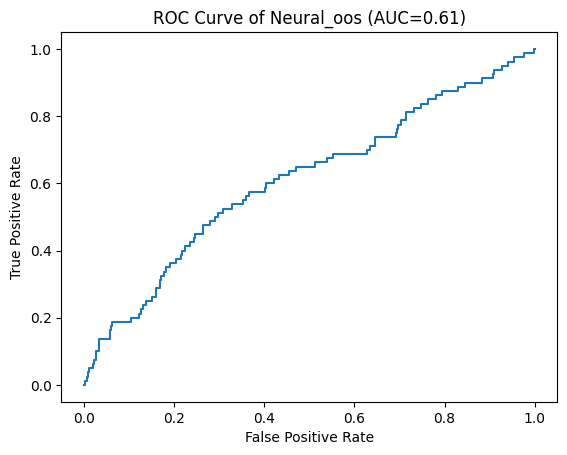

In [49]:
mod = MLPClassifier(hidden_layer_sizes=(100,100), max_iter=1000)
rres = mod.fit(y = y_train, X=X_train)
_, auc_neural_oos = plot_roc_curve(y_test, mod.predict_proba(X_test)[:,1],'Neural_oos')

# Conclusion

In [51]:
auc_compare = pd.DataFrame({'Model': ['Simple Logistic', 'Logistic with log income', 'Full Logistic', 'SVM RBF', 'SVM Sigmoid', 'SVM Poly', 'Random Forest', 'XGBoosting', 'Neural Network'],'auc': [auc_simplog, auc_simplog_logtransform, auc_log, auc_rbfsvm, auc_sigmoidsvm, auc_polysvm, auc_RF , auc_XGBoosting, auc_neural]})
auc_compare.to_latex('table/auc_compare.tex',index=False,float_format="%.2f",caption='AUC Comparison', label='tab:auc_compare')

In [52]:
auc_oos_compare = pd.DataFrame({'Model': ['Logistic', 'SVM RBF', 'Random Forest', 'XGBoosting', 'Neural Network'],'auc': [auc_log_oos, auc_svm_oos, auc_RFoos, auc_XGBoostingoos, auc_neural_oos]})
auc_oos_compare.to_latex('table/auc_oos_compare.tex',index=False,float_format="%.2f",caption='AUC Comparison (Out of Sample)', label='tab:auc_oos_compare')